In [8]:
!pip install pandas fastparquet

  Using cached fastparquet-2023.10.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached cramjam-2.7.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.0 kB)
Using cached fastparquet-2023.10.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.8 MB)
Using cached cramjam-2.7.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.0/169.0 kB 1.3 MB/s eta 0:00:00a 0:00:01m


In [18]:
import pandas as pd
import numpy as np

In [19]:
df = pd.read_parquet(f'masked_all_func_body_v1.parquet', engine='fastparquet')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74288 entries, 0 to 74287
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   source_idx                 74288 non-null  object
 1   contract_name              74288 non-null  object
 2   func_name                  58521 non-null  object
 3   masked_contract            74288 non-null  object
 4   func_body                  74288 non-null  object
 5   func_body_removed_comment  74288 non-null  object
dtypes: object(6)
memory usage: 3.4+ MB


In [23]:
df.head(10)

,source_idx,contract_name,func_name,masked_contract,func_body,func_body_removed_comment
0,98056,DataDump,postData,contract DataDump is Owned {\n\tevent DataDump...,"\r\n\t\tDataDumped(recipient, topic, data);\r\n\t","\n\t\tDataDumped(recipient, topic, data);\n\t"
1,4152,SolidusToken,disablePurchasing,contract SolidusToken {\n\r\n address owner...,\r\n require(msg.sender == owner);\r\n ...,\n require(msg.sender == owner);\n ...
2,5258,HegicERCPool,send,"contract HegicERCPool is IERCLiquidityPool, Ow...","\r\n require(lockedAmount >= amount, ...","\n require(lockedAmount >= amount, ""P..."
3,86192,ElmerFudd,None,"contract ElmerFudd is Context, IERC20, Ownable...",\r\n _feeAddrWallet1 = payable(0x75395C...,\n _feeAddrWallet1 = payable(0x75395C7F...
4,105452,ERC20,transferFrom,"contract ERC20 is ERC20Interface,SafeMath {\n\...",\r\n require(_to != address(0));\r\n ...,\n require(_to != address(0));\n req...
5,44079,Advertisement,areNoncesValid,contract Advertisement {\n\r\n struct Valid...,\r\n\r\n for(uint i = 0; i < nonces.len...,\n\n for(uint i = 0; i < nonces.length;...
6,82440,BlindCroupierTokenDistribution,isPeriodClosed,contract BlindCroupierTokenDistribution is Mul...,\r\n return period < currentPeriod;\r...,\n return period < currentPeriod;\n
7,31623,PiggyBank,debugDestruct,contract PiggyBank {\n string public name;\r...,\r\n selfdestruct(targetAddress);\r\n,\n selfdestruct(targetAddress);\n
8,80907,UniswapInterfaceMulticall,multicall,contract UniswapInterfaceMulticall {\n stru...,\n blockNumber = block.number;\n ...,\n blockNumber = block.number;\n ...
9,20406,ALLCASH,ALLCASH,"contract ALLCASH is ERC20Interface, Owned, Saf...","\r\n symbol = ""ACH"";\r\n name = ...","\n symbol = ""ACH"";\n name = ""ALL..."


In [5]:
!

In [21]:
from transformers import AutoTokenizer, AutoModelForCausalLM
model_id = 'deepseek-ai/deepseek-coder-6.7b-base'

tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True, )

In [16]:
eval_prompt = 'def xyz'
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

In [17]:
model_input['input_ids'].size()[1]

5

In [22]:
from tqdm import tqdm

In [23]:
input_ls = []
output_ls = []
with tqdm(total=len(df), desc="gen") as pbar:
    for _, row in df.iterrows():
        model_input = tokenizer(row['masked_contract'], return_tensors="pt").to("cuda")
        input_ls.append(model_input['input_ids'].size()[1])
        model_input = tokenizer(row['func_body'], return_tensors="pt").to("cuda")
        output_ls.append(model_input['input_ids'].size()[1])
        pbar.update(1)

gen:   0%|          | 0/74288 [00:00<?, ?it/s]

gen: 100%|██████████| 74288/74288 [17:26<00:00, 70.98it/s] 


In [27]:
df['len_input'] = input_ls
df['len_output'] = output_ls

In [28]:
df['total'] = df['len_input'] + df['len_output']

In [43]:
len(df[df['len_output'] <= 256]) / len(df)

0.8699520783975878

<Axes: xlabel='len_output'>

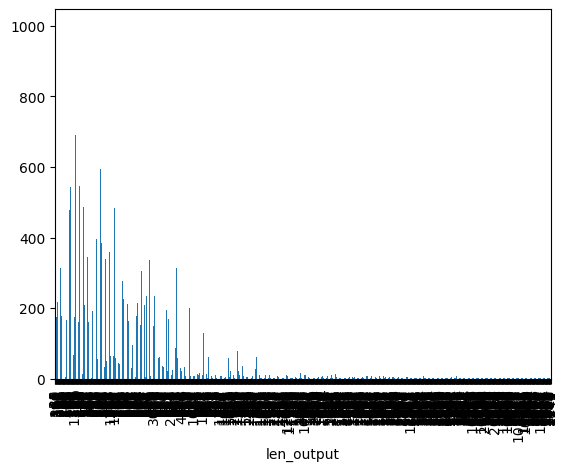

In [39]:
df['len_output'].value_counts()[df['len_output'].unique()].plot(kind='bar')

In [30]:
len(df[df['total'] <= 2048])

51366

In [32]:
df.head(10)

,source_idx,contract_name,func_name,masked_contract,func_body,func_body_removed_comment,len_input,len_output,total
0,98056,DataDump,postData,contract DataDump is Owned {\n\tevent DataDump...,"\r\n\t\tDataDumped(recipient, topic, data);\r\n\t","\n\t\tDataDumped(recipient, topic, data);\n\t",84,20,104
1,4152,SolidusToken,disablePurchasing,contract SolidusToken {\n\r\n address owner...,\r\n require(msg.sender == owner);\r\n ...,\n require(msg.sender == owner);\n ...,1175,25,1200
2,5258,HegicERCPool,send,"contract HegicERCPool is IERCLiquidityPool, Ow...","\r\n require(lockedAmount >= amount, ...","\n require(lockedAmount >= amount, ""P...",1463,61,1524
3,86192,ElmerFudd,None,"contract ElmerFudd is Context, IERC20, Ownable...",\r\n _feeAddrWallet1 = payable(0x75395C...,\n _feeAddrWallet1 = payable(0x75395C7F...,3457,267,3724
4,105452,ERC20,transferFrom,"contract ERC20 is ERC20Interface,SafeMath {\n\...",\r\n require(_to != address(0));\r\n ...,\n require(_to != address(0));\n req...,476,184,660
5,44079,Advertisement,areNoncesValid,contract Advertisement {\n\r\n struct Valid...,\r\n\r\n for(uint i = 0; i < nonces.len...,\n\n for(uint i = 0; i < nonces.length;...,3310,399,3709
6,82440,BlindCroupierTokenDistribution,isPeriodClosed,contract BlindCroupierTokenDistribution is Mul...,\r\n return period < currentPeriod;\r...,\n return period < currentPeriod;\n,4853,14,4867
7,31623,PiggyBank,debugDestruct,contract PiggyBank {\n string public name;\r...,\r\n selfdestruct(targetAddress);\r\n,\n selfdestruct(targetAddress);\n,290,14,304
8,80907,UniswapInterfaceMulticall,multicall,contract UniswapInterfaceMulticall {\n stru...,\n blockNumber = block.number;\n ...,\n blockNumber = block.number;\n ...,179,163,342
9,20406,ALLCASH,ALLCASH,"contract ALLCASH is ERC20Interface, Owned, Saf...","\r\n symbol = ""ACH"";\r\n name = ...","\n symbol = ""ACH"";\n name = ""ALL...",1167,176,1343


In [24]:

df['len_input'] = df['masked_contract'].apply(lambda x: tokenizer(x, return_tensors="pt").to("cuda")['input_ids'].size()[1])
# df['len_output'] = df['function_body'].apply(lambda x: len(str(x).split()))
# df['total'] = df['len_input'] + df['len_output']

Token indices sequence length is longer than the specified maximum sequence length for this model (16413 > 16384). Running this sequence through the model will result in indexing errors


KeyboardInterrupt: 

In [ ]:
temp = df[df['total'] < 1024]

In [15]:
temp = temp[temp['len_output'] < 50]

In [7]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44152 entries, 2 to 76143
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   index                 44152 non-null  int64 
 1   file_address          44152 non-null  object
 2   contract_name         44152 non-null  object
 3   function_name         44152 non-null  object
 4   contract_masked       44152 non-null  object
 5   function_body         44152 non-null  object
 6   function_requirement  44152 non-null  object
 7   len_input             44152 non-null  int64 
 8   len_output            44152 non-null  int64 
 9   total                 44152 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 3.7+ MB


In [12]:
temp.head(10)

,index,file_address,contract_name,function_name,contract_masked,function_body,function_requirement,len_input,len_output,total
0,0,0x5db4b520284049d7dcb21c6317664190791bb8e5,TangentStake,TangentStake,contract TangentStake is Owned {\r\n // pre...,\r\n tokenContract = Tangent(tokenAddre...,"constructor, sets initial rate to 1000 TAN per...",478,15,493
1,1,0x5db4b520284049d7dcb21c6317664190791bb8e5,TangentStake,revalue,contract TangentStake is Owned {\r\n // pre...,\r\n require( (newMul.div(newDiv)) <= (...,"decreases the rate of Tangents to Ether, the c...",477,16,493
2,2,0x5db4b520284049d7dcb21c6317664190791bb8e5,TangentStake,getEarnings,contract TangentStake is Owned {\r\n // pre...,\r\n Purchase memory cpurchase;\r\n ...,returns the current amount of wei that will be...,449,44,493
3,3,0x5db4b520284049d7dcb21c6317664190791bb8e5,TangentStake,cashOut,contract TangentStake is Owned {\r\n // pre...,\r\n require(0 <= index && index < purc...,Cash out Ether and Tangent at for the purchase...,448,45,493
4,5,0xbc99a5e7764792cd1024fd5310e9867ee578c23d,CoFiXVaultForLP,setGovernance,"contract CoFiXVaultForLP is ICoFiXVaultForLP, ...",\n governance = _new;\n,setters for protocol governance,889,3,892
5,6,0xbc99a5e7764792cd1024fd5310e9867ee578c23d,CoFiXVaultForLP,getEnabledPoolCnt,"contract CoFiXVaultForLP is ICoFiXVaultForLP, ...",\n return enabledCnt;\n,pools in enabled state,890,2,892
31,34,0x3929ffab35937ab32f6ea0d9849174161d9d20c7,Registry,mapToken,contract Registry is Governable {\n // @tod...,\n require(_rootToken != address(0x0) &...,*\n * @dev Map root token to child token\n...,433,21,454
32,35,0x0069e491f2ed9e562a7c9c92ba40f73d946718e0,SafeMath,safeMul,contract SafeMath {\r\n //internals\r\n\r\n...,\r\n uint c = a * b;\r\n assert(...,internals,53,17,70
33,36,0x0069e491f2ed9e562a7c9c92ba40f73d946718e0,Crowdsale,Crowdsale,"contract Crowdsale is owned, SafeMath {\r\n ...",\r\n beneficiary = 0xe579891b98a3f58e26...,*\r\n * Constrctor function\r\n *\r\n ...,417,38,455
34,37,0x0069e491f2ed9e562a7c9c92ba40f73d946718e0,Crowdsale,getNumTokens,"contract Crowdsale is owned, SafeMath {\r\n ...",\r\n require(_value>=10000000000000000 ...,It calculates the amount of tokens to send to ...,393,62,455


In [15]:
len(temp[temp['len_output'] < 50]) / len(temp)

0.9248899044630791

In [10]:
temp = temp[temp['len_output'] > 0]

In [11]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 432971 entries, 0 to 740795
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   index                 432971 non-null  int64 
 1   file_address          432971 non-null  object
 2   contract_name         432971 non-null  object
 3   function_name         432971 non-null  object
 4   contract_masked       432971 non-null  object
 5   function_body         432971 non-null  object
 6   function_requirement  432971 non-null  object
 7   len_input             432971 non-null  int64 
 8   len_output            432971 non-null  int64 
 9   total                 432971 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 36.3+ MB


In [21]:
temp = temp.dropna(axis=0, subset=['contract_masked'])

In [22]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740796 entries, 0 to 740795
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   index                 740796 non-null  int64 
 1   file_address          740796 non-null  object
 2   contract_name         740796 non-null  object
 3   function_name         740796 non-null  object
 4   contract_masked       740796 non-null  object
 5   function_body         740796 non-null  object
 6   function_requirement  740796 non-null  object
dtypes: int64(1), object(6)
memory usage: 39.6+ MB


In [28]:
dummp = temp.isnull().sum()

In [29]:
dummp

24560

In [12]:
temp_d = temp[['file_address','contract_name']]

In [19]:
df_d = df[['file_address','contract_name']]

In [24]:
temp_d.head(10)

,file_address,contract_name
0,0x5db4b520284049d7dcb21c6317664190791bb8e5,TangentStake
1,0x5db4b520284049d7dcb21c6317664190791bb8e5,TangentStake
2,0x5db4b520284049d7dcb21c6317664190791bb8e5,TangentStake
3,0x5db4b520284049d7dcb21c6317664190791bb8e5,TangentStake
4,0xbc99a5e7764792cd1024fd5310e9867ee578c23d,CoFiXVaultForLP
5,0xbc99a5e7764792cd1024fd5310e9867ee578c23d,CoFiXVaultForLP
6,0x3e4318d6cf48cfcffdd09a7c382850c8bfa328e9,ERC721
7,0x3e4318d6cf48cfcffdd09a7c382850c8bfa328e9,ERC721
8,0x3e4318d6cf48cfcffdd09a7c382850c8bfa328e9,ERC721
9,0x3e4318d6cf48cfcffdd09a7c382850c8bfa328e9,ERC721


In [13]:
records = temp_d.drop_duplicates().to_dict("records") 

In [21]:
df_records = df_d.drop_duplicates().to_dict("records") 

In [22]:
len(records) / len(df_records)

0.8494859512202025

In [9]:
temp_d.info()

<class 'pandas.core.frame.DataFrame'>
Index: 468208 entries, 0 to 740795
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   file_address   468208 non-null  object
 1   contract_name  468208 non-null  object
dtypes: object(2)
memory usage: 10.7+ MB


In [14]:
len(df_records)

NameError: name 'df_records' is not defined

In [15]:
len(records)

115686

In [1]:
import datasets

raw = datasets.load_dataset('lvdthieu/codegen-v3', split='train')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetGenerationError: An error occurred while generating the dataset

In [16]:
import random

random.seed(42)
records = random.sample(records, 30000)

In [26]:
records[:10]

[{'file_address': '0x0bfa3b4ab5bb54a920783aedc46101bf4bcad7a0',
  'contract_name': 'Ownable'},
 {'file_address': '0x7fa2f70bd4c4120fdd539ebd55c04118ba336b9e',
  'contract_name': 'Ownable'},
 {'file_address': '0x1fb62df2b6ef8966161e422dbb40860b70941e50',
  'contract_name': 'Pausable'},
 {'file_address': '0xbe7decf6ec9227263fa29da0b2aa41e3d5a95eec',
  'contract_name': 'PricingStrategy'},
 {'file_address': '0xce7f1e469a551d67fbd008aeeefdd1f9a0932fcf',
  'contract_name': 'iERC20v1'},
 {'file_address': '0x23eb30d47674feaaf195056cb6e7ceebf36ef0b2',
  'contract_name': 'GoodLuckCoin'},
 {'file_address': '0x92b7cf443f427bc01d57f6cb0854f400b7d956da',
  'contract_name': 'Context'},
 {'file_address': '0x78ccf97204bbc6acae44d68a60af89317e4f5b5b',
  'contract_name': 'Ownable'},
 {'file_address': '0xa1a85a763b252ff7253b8829d4fb60d526e517ca',
  'contract_name': 'Token'},
 {'file_address': '0xd05e6d87bef06e409888b0b0be450750575d5a4e',
  'contract_name': 'BasicToken'}]

In [27]:
len(records)

30000

In [19]:
file_list = temp['file_address'].unique()

In [21]:
random.seed(42)
file_list = random.sample(sorted(file_list), 30000)

In [21]:
!pip install tqdm

  Using cached tqdm-4.66.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.66.1-py3-none-any.whl (78 kB)


In [29]:
temp.head(10)

,index,file_address,contract_name,function_name,contract_masked,function_body,function_requirement
0,0,0x5db4b520284049d7dcb21c6317664190791bb8e5,TangentStake,TangentStake,contract TangentStake is Owned {\r\n // pre...,\r\n tokenContract = Tangent(tokenAddre...,"constructor, sets initial rate to 1000 TAN per..."
1,1,0x5db4b520284049d7dcb21c6317664190791bb8e5,TangentStake,revalue,contract TangentStake is Owned {\r\n // pre...,\r\n require( (newMul.div(newDiv)) <= (...,"decreases the rate of Tangents to Ether, the c..."
2,2,0x5db4b520284049d7dcb21c6317664190791bb8e5,TangentStake,getEarnings,contract TangentStake is Owned {\r\n // pre...,\r\n Purchase memory cpurchase;\r\n ...,returns the current amount of wei that will be...
3,3,0x5db4b520284049d7dcb21c6317664190791bb8e5,TangentStake,cashOut,contract TangentStake is Owned {\r\n // pre...,\r\n require(0 <= index && index < purc...,Cash out Ether and Tangent at for the purchase...
4,5,0xbc99a5e7764792cd1024fd5310e9867ee578c23d,CoFiXVaultForLP,setGovernance,"contract CoFiXVaultForLP is ICoFiXVaultForLP, ...",\n governance = _new;\n,setters for protocol governance
5,6,0xbc99a5e7764792cd1024fd5310e9867ee578c23d,CoFiXVaultForLP,getEnabledPoolCnt,"contract CoFiXVaultForLP is ICoFiXVaultForLP, ...",\n return enabledCnt;\n,pools in enabled state
6,8,0x3e4318d6cf48cfcffdd09a7c382850c8bfa328e9,ERC721,supportsInterface,"contract ERC721 is Context, ERC165, IERC721, I...",\r\n return\r\n interfaceId ...,*\r\n * @dev See {IERC165-supportsInterface}.
7,9,0x3e4318d6cf48cfcffdd09a7c382850c8bfa328e9,ERC721,balanceOf,"contract ERC721 is Context, ERC165, IERC721, I...",\r\n require(\r\n owner != a...,*\r\n * @dev See {IERC721-balanceOf}.
8,10,0x3e4318d6cf48cfcffdd09a7c382850c8bfa328e9,ERC721,ownerOf,"contract ERC721 is Context, ERC165, IERC721, I...",\r\n address owner = _owners[tokenId];\...,*\r\n * @dev See {IERC721-ownerOf}.
9,11,0x3e4318d6cf48cfcffdd09a7c382850c8bfa328e9,ERC721,name,"contract ERC721 is Context, ERC165, IERC721, I...",\r\n return _name;\r\n,*\r\n * @dev See {IERC721Metadata-name}.


In [23]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 432971 entries, 0 to 740795
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   index                 432971 non-null  int64 
 1   file_address          432971 non-null  object
 2   contract_name         432971 non-null  object
 3   function_name         432971 non-null  object
 4   contract_masked       432971 non-null  object
 5   function_body         432971 non-null  object
 6   function_requirement  432971 non-null  object
 7   len_input             432971 non-null  int64 
 8   len_output            432971 non-null  int64 
 9   total                 432971 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 36.3+ MB


In [25]:
len(file_list)

30000

In [29]:
records[:10]

[{'file_address': '0x0bfa3b4ab5bb54a920783aedc46101bf4bcad7a0',
  'contract_name': 'Ownable'},
 {'file_address': '0x7fa2f70bd4c4120fdd539ebd55c04118ba336b9e',
  'contract_name': 'Ownable'},
 {'file_address': '0x1fb62df2b6ef8966161e422dbb40860b70941e50',
  'contract_name': 'Pausable'},
 {'file_address': '0xbe7decf6ec9227263fa29da0b2aa41e3d5a95eec',
  'contract_name': 'PricingStrategy'},
 {'file_address': '0xce7f1e469a551d67fbd008aeeefdd1f9a0932fcf',
  'contract_name': 'iERC20v1'},
 {'file_address': '0x23eb30d47674feaaf195056cb6e7ceebf36ef0b2',
  'contract_name': 'GoodLuckCoin'},
 {'file_address': '0x92b7cf443f427bc01d57f6cb0854f400b7d956da',
  'contract_name': 'Context'},
 {'file_address': '0x78ccf97204bbc6acae44d68a60af89317e4f5b5b',
  'contract_name': 'Ownable'},
 {'file_address': '0xa1a85a763b252ff7253b8829d4fb60d526e517ca',
  'contract_name': 'Token'},
 {'file_address': '0xd05e6d87bef06e409888b0b0be450750575d5a4e',
  'contract_name': 'BasicToken'}]

In [32]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 432971 entries, 0 to 740795
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   index                 432971 non-null  int64 
 1   file_address          432971 non-null  object
 2   contract_name         432971 non-null  object
 3   function_name         432971 non-null  object
 4   contract_masked       432971 non-null  object
 5   function_body         432971 non-null  object
 6   function_requirement  432971 non-null  object
 7   len_input             432971 non-null  int64 
 8   len_output            432971 non-null  int64 
 9   total                 432971 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 36.3+ MB


In [37]:
from tqdm import tqdm
examples = []
with tqdm(total=30000, desc="gen") as pbar:
    # print( records[:1])
    for record in records:
        # print(file_address, contract_name)
        file_address = record['file_address']
        contract_name = record['contract_name']
    #     print(address)
        # address = file_list[0]
        df_temp = temp[temp['file_address'] == file_address]

        # print(df_temp)
        # contract_list = df_temp['contract_name'].unique()
        
        # for contract in contract_list:
        df_contract_temp = df_temp[df_temp['contract_name'] == contract_name]
        df_contract_temp = df_contract_temp.sample(n=1)
        source_seq = ''
        target_seq = ''
        for _, row in df_contract_temp.iterrows():
            source_seq = ' '.join(row['contract_masked'].split())
            target_seq = ' '.join(row['function_body'].split())
            examples.append({
                'file_address': row['file_address'], 
                'contract_name': row['contract_name'],
                'func_name': row['function_name'],
                'masked_contract': source_seq, 
                'func_body': target_seq
            })
            pbar.update(1)

    # df_temp = df_temp.sample(n=1, random_state=42)
    # source_seq = ''
    # target_seq = ''
    # for _, row in df_temp.iterrows():
    #     source_seq = ' '.join(row['Contract masked'].split())
    #     target_seq = row['Function body']
    #     examples.append({'masked_contract': source_seq, 'func_body': target_seq})
import json
def dump_to_file(obj, file):
    with open(file,'w+') as f:
        for el in obj:
            f.write(json.dumps(el)+'\n')
    
dump_to_file(examples,'train_30k.jsonl') 


gen: 100%|██████████| 30000/30000 [29:36<00:00, 16.89it/s]


In [39]:

examples_clean = []

for example in tqdm(examples):
    examples_clean.append({
        'file_address': example['file_address'], 
        'contract_name': example['contract_name'],
        'func_name': example['func_name'],
        'masked_contract': example['masked_contract'], 
        'func_body': example['func_body']
    })

import json
def dump_to_file(obj, file):
    with open(file,'w+') as f:
        for el in obj:
            f.write(json.dumps(el)+'\n')
    
dump_to_file(examples_clean,'clean/train.jsonl')

  0%|          | 0/30000 [00:00<?, ?it/s]

100%|██████████| 30000/30000 [00:00<00:00, 65536.99it/s] 


In [1]:
import datasets

raw = datasets.load_dataset('lvdthieu/codegen', split='test')

/home/dungbt/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

KeyboardInterrupt: 

In [1]:
import pandas as pd

df = pd.read_parquet(f'masked_all_func_body_v1.parquet', engine='fastparquet')


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74288 entries, 0 to 74287
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   source_idx                 74288 non-null  object
 1   contract_name              74288 non-null  object
 2   func_name                  58521 non-null  object
 3   masked_contract            74288 non-null  object
 4   func_body                  74288 non-null  object
 5   func_body_removed_comment  74288 non-null  object
dtypes: object(6)
memory usage: 3.4+ MB


In [3]:
df.head(10)

,source_idx,contract_name,func_name,masked_contract,func_body,func_body_removed_comment
0,98056,DataDump,postData,contract DataDump is Owned {\n\tevent DataDump...,"\r\n\t\tDataDumped(recipient, topic, data);\r\n\t","\n\t\tDataDumped(recipient, topic, data);\n\t"
1,4152,SolidusToken,disablePurchasing,contract SolidusToken {\n\r\n address owner...,\r\n require(msg.sender == owner);\r\n ...,\n require(msg.sender == owner);\n ...
2,5258,HegicERCPool,send,"contract HegicERCPool is IERCLiquidityPool, Ow...","\r\n require(lockedAmount >= amount, ...","\n require(lockedAmount >= amount, ""P..."
3,86192,ElmerFudd,None,"contract ElmerFudd is Context, IERC20, Ownable...",\r\n _feeAddrWallet1 = payable(0x75395C...,\n _feeAddrWallet1 = payable(0x75395C7F...
4,105452,ERC20,transferFrom,"contract ERC20 is ERC20Interface,SafeMath {\n\...",\r\n require(_to != address(0));\r\n ...,\n require(_to != address(0));\n req...
5,44079,Advertisement,areNoncesValid,contract Advertisement {\n\r\n struct Valid...,\r\n\r\n for(uint i = 0; i < nonces.len...,\n\n for(uint i = 0; i < nonces.length;...
6,82440,BlindCroupierTokenDistribution,isPeriodClosed,contract BlindCroupierTokenDistribution is Mul...,\r\n return period < currentPeriod;\r...,\n return period < currentPeriod;\n
7,31623,PiggyBank,debugDestruct,contract PiggyBank {\n string public name;\r...,\r\n selfdestruct(targetAddress);\r\n,\n selfdestruct(targetAddress);\n
8,80907,UniswapInterfaceMulticall,multicall,contract UniswapInterfaceMulticall {\n stru...,\n blockNumber = block.number;\n ...,\n blockNumber = block.number;\n ...
9,20406,ALLCASH,ALLCASH,"contract ALLCASH is ERC20Interface, Owned, Saf...","\r\n symbol = ""ACH"";\r\n name = ...","\n symbol = ""ACH"";\n name = ""ALL..."


In [4]:
df['len_input'] = df['masked_contract'].apply(lambda x: len(str(x).split()))
df['len_output'] = df['func_body_removed_comment'].apply(lambda x: len(str(x).split()))
df['total'] = df['len_input'] + df['len_output']

In [20]:
temp = df[df['func_name'].isnull()]

In [21]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15767 entries, 3 to 74284
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   source_idx                 15767 non-null  object
 1   contract_name              15767 non-null  object
 2   func_name                  0 non-null      object
 3   masked_contract            15767 non-null  object
 4   func_body                  15767 non-null  object
 5   func_body_removed_comment  15767 non-null  object
 6   len_input                  15767 non-null  int64 
 7   len_output                 15767 non-null  int64 
 8   total                      15767 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 1.2+ MB


In [5]:
temp['len_output'].describe()

NameError: name 'temp' is not defined

In [5]:
df['total'].describe()

count    74288.000000
mean       541.861445
std        846.069758
min          8.000000
25%        147.000000
50%        343.000000
75%        744.000000
max      73216.000000
Name: total, dtype: float64

In [6]:
len(df[df['len_output'] < 45]) / len(df)

0.898853112211932

In [7]:
len(df[df['total'] < 1024]) / len(df)

0.860892741761792

In [8]:
df = df[df['total'] < 1024]

In [9]:
df = df[df['len_output'] < 40]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58001 entries, 0 to 74287
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   source_idx                 58001 non-null  object
 1   contract_name              58001 non-null  object
 2   func_name                  44093 non-null  object
 3   masked_contract            58001 non-null  object
 4   func_body                  58001 non-null  object
 5   func_body_removed_comment  58001 non-null  object
 6   len_input                  58001 non-null  int64 
 7   len_output                 58001 non-null  int64 
 8   total                      58001 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 4.4+ MB


In [13]:
from tqdm import tqdm

from transformers import AutoTokenizer, AutoModelForCausalLM
model_id = 'deepseek-ai/deepseek-coder-6.7b-base'

tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True, )

input_ls = []
output_ls = []
with tqdm(total=len(df), desc="gen") as pbar:
    for _, row in df.iterrows():
        model_input = tokenizer(row['masked_contract'], return_tensors="pt").to("cuda")
        input_ls.append(model_input['input_ids'].size()[1])
        model_input = tokenizer(row['func_body'], return_tensors="pt").to("cuda")
        output_ls.append(model_input['input_ids'].size()[1])
        pbar.update(1)

gen: 100%|██████████| 58001/58001 [09:34<00:00, 100.95it/s]


In [14]:
df['len_input'] = input_ls
df['len_output'] = output_ls

In [15]:
df['total'] = df['len_input'] + df['len_output']

In [17]:
len(df[df['total'] < 2048])

48034

In [16]:
len(df[df['total'] < 2048])/ len(df)

0.8281581352045655

In [11]:
df.head(2)

,source_idx,contract_name,func_name,masked_contract,func_body,func_body_removed_comment,len_input,len_output,total
0,98056,DataDump,postData,contract DataDump is Owned {\n\tevent DataDump...,"\r\n\t\tDataDumped(recipient, topic, data);\r\n\t","\n\t\tDataDumped(recipient, topic, data);\n\t",27,3,30
1,4152,SolidusToken,disablePurchasing,contract SolidusToken {\n\r\n address owner...,\r\n require(msg.sender == owner);\r\n ...,\n require(msg.sender == owner);\n ...,313,6,319


<Axes: >

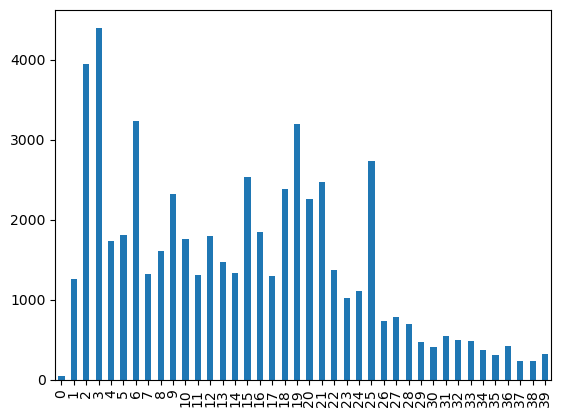

In [12]:
df['len_output'].value_counts().sort_index().plot.bar()

In [13]:
idx = df['source_idx'].unique().tolist()



In [14]:
idx

['98056',
 '4152',
 '5258',
 '86192',
 '105452',
 '31623',
 '20406',
 '49298',
 '6536',
 '100499',
 '69340',
 '53830',
 '42378',
 '118288',
 '182',
 '30596',
 '22486',
 '19686',
 '69384',
 '65681',
 '68733',
 '35858',
 '71423',
 '24431',
 '64351',
 '102379',
 '118492',
 '47508',
 '3271',
 '1058',
 '80941',
 '43037',
 '69824',
 '114174',
 '27630',
 '30733',
 '60829',
 '57516',
 '67741',
 '103858',
 '98831',
 '43299',
 '37057',
 '30719',
 '17624',
 '59300',
 '74539',
 '6874',
 '16133',
 '50574',
 '53574',
 '47064',
 '17287',
 '45404',
 '117452',
 '18618',
 '82017',
 '75547',
 '89180',
 '76317',
 '1744',
 '94443',
 '50332',
 '118579',
 '45654',
 '63788',
 '66215',
 '114595',
 '85740',
 '102013',
 '32676',
 '56522',
 '17144',
 '107259',
 '106014',
 '72681',
 '65201',
 '36050',
 '25008',
 '60776',
 '61518',
 '42937',
 '41020',
 '103697',
 '88506',
 '33674',
 '50204',
 '58610',
 '40479',
 '116915',
 '42333',
 '10120',
 '5464',
 '66212',
 '85429',
 '41077',
 '14342',
 '76252',
 '83302',
 '751

In [18]:
idx.sort()

In [17]:
sorted(idx)

['1',
 '100003',
 '100005',
 '100007',
 '100009',
 '100010',
 '100012',
 '100013',
 '100014',
 '100015',
 '100016',
 '100017',
 '10002',
 '100021',
 '100023',
 '100026',
 '10003',
 '100031',
 '100034',
 '100035',
 '100036',
 '100039',
 '10004',
 '100040',
 '100041',
 '100044',
 '100045',
 '10005',
 '100051',
 '100052',
 '100053',
 '100054',
 '100057',
 '100058',
 '100060',
 '100061',
 '100062',
 '100063',
 '100064',
 '100065',
 '10007',
 '100071',
 '100072',
 '100073',
 '100074',
 '100076',
 '100078',
 '10008',
 '100083',
 '100084',
 '100086',
 '100087',
 '100088',
 '100089',
 '10009',
 '100090',
 '100095',
 '100097',
 '100098',
 '10010',
 '100101',
 '100106',
 '100113',
 '100114',
 '100115',
 '100118',
 '100119',
 '10012',
 '100122',
 '100123',
 '100124',
 '100125',
 '100127',
 '100131',
 '100133',
 '100134',
 '100137',
 '100138',
 '100139',
 '10014',
 '100140',
 '100142',
 '100144',
 '100146',
 '100149',
 '10015',
 '100150',
 '100152',
 '100155',
 '100156',
 '100157',
 '100161',
 '10

In [19]:
import random 
random.seed(42)
idx = random.sample(sorted(idx), 30000)

In [20]:
idx

['70641',
 '113030',
 '102897',
 '83049',
 '26554',
 '22858',
 '20108',
 '116326',
 '82425',
 '111997',
 '75151',
 '82950',
 '5955',
 '11012',
 '64808',
 '44537',
 '103697',
 '103457',
 '110939',
 '1956',
 '21316',
 '54745',
 '66224',
 '103080',
 '61399',
 '1710',
 '79979',
 '71885',
 '78219',
 '59503',
 '44229',
 '19770',
 '47851',
 '64672',
 '26943',
 '91158',
 '98155',
 '100767',
 '85108',
 '90745',
 '11938',
 '77838',
 '44616',
 '34477',
 '26908',
 '11823',
 '19106',
 '85695',
 '34082',
 '111954',
 '110820',
 '39343',
 '111298',
 '36810',
 '95602',
 '34929',
 '66434',
 '25258',
 '90894',
 '105032',
 '81618',
 '49135',
 '58431',
 '114594',
 '39175',
 '109215',
 '60327',
 '28774',
 '93523',
 '6936',
 '68176',
 '97240',
 '37120',
 '63330',
 '1625',
 '78613',
 '108156',
 '10531',
 '73267',
 '20683',
 '86831',
 '28314',
 '109318',
 '96490',
 '21327',
 '97802',
 '11182',
 '39368',
 '26915',
 '48361',
 '70207',
 '94051',
 '3753',
 '12356',
 '38153',
 '36322',
 '18414',
 '74401',
 '25563',

In [22]:
temp = df[~df['source_idx'].isin(idx)]

In [23]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28001 entries, 0 to 74287
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   source_idx                 28001 non-null  object
 1   contract_name              28001 non-null  object
 2   func_name                  21342 non-null  object
 3   masked_contract            28001 non-null  object
 4   func_body                  28001 non-null  object
 5   func_body_removed_comment  28001 non-null  object
 6   len_input                  28001 non-null  int64 
 7   len_output                 28001 non-null  int64 
 8   total                      28001 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 2.1+ MB


In [24]:
df = temp

In [48]:
train_percent = 0.8
train_index = sorted(set(df['source_idx'].sample(int(df['source_idx'].nunique() * train_percent), random_state=42)))
test_index = sorted(set(df[~df['source_idx'].isin(train_index)]['source_idx']))

In [25]:
from tqdm import tqdm
import re

examples = []
# with tqdm(total=len(train_index), desc="gen") as pbar:
for _, row in df.iterrows():
    # df_commit = df[df['source_idx']==index]
    source_seq = ''
    target_seq = ''
    # deepseek_seq = ''
    # for _, row in df_commit.iterrows():
    source_seq = row['masked_contract']
    # deepseek_seq = str(row['predict'])
    target_seq = row['func_body_removed_comment']
    except_no_english = r'[^\sa-zA-Z0-9.!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~]'
    source_seq = re.sub(except_no_english, '', source_seq)
    # deepseek_seq = re.sub(except_no_english, '', deepseek_seq)
    target_seq = re.sub(except_no_english, '', target_seq)
    examples.append({
        'contract_name': row['contract_name'],
        'func_name': row['func_name'],
        'func_body': row['func_body'],
        'source_idx': row['source_idx'],
        'masked_contract': source_seq, 
        'func_body_removed_comment': target_seq
    })
    
    # pbar.update(1)

import json
def dump_to_file(obj, file):
    with open(file,'w+') as f:
        for el in obj:
            f.write(json.dumps(el)+'\n')
            
dump_to_file(examples,'data-30k/valid.jsonl')

In [51]:
from tqdm import tqdm
import re

examples = []
# with tqdm(total=len(train_index), desc="gen") as pbar:
for index in tqdm(train_index):
    df_commit = df[df['source_idx']==index]
    source_seq = ''
    target_seq = ''
    # deepseek_seq = ''
    for _, row in df_commit.iterrows():
        source_seq = row['masked_contract']
        # deepseek_seq = str(row['predict'])
        target_seq = row['func_body_removed_comment']
        except_no_english = r'[^\sa-zA-Z0-9.!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~]'
        source_seq = re.sub(except_no_english, '', source_seq)
        # deepseek_seq = re.sub(except_no_english, '', deepseek_seq)
        target_seq = re.sub(except_no_english, '', target_seq)
        examples.append({
            'contract_name': row['contract_name'],
            'func_name': row['func_name'],
            'func_body': row['func_body'],
            'source_idx': row['source_idx'],
            'masked_contract': source_seq, 
            'func_body_removed_comment': target_seq
        })
    
    # pbar.update(1)

import json
def dump_to_file(obj, file):
    with open(file,'w+') as f:
        for el in obj:
            f.write(json.dumps(el)+'\n')
            
dump_to_file(examples,'data-30k/train.jsonl')

  0%|          | 0/24000 [00:00<?, ?it/s]

100%|██████████| 24000/24000 [01:55<00:00, 207.48it/s]


In [19]:
len(train_index)

46400

In [14]:
df['source_idx'].nunique() 

58001

In [28]:
len(df[df['len_output'] < 40]) / len(df)

0.9069174719329518

In [7]:
df['len_output'].describe()

count    74288.000000
mean        23.123910
std         44.366902
min          0.000000
25%          6.000000
50%         16.000000
75%         25.000000
max       7606.000000
Name: len_output, dtype: float64

<Axes: >

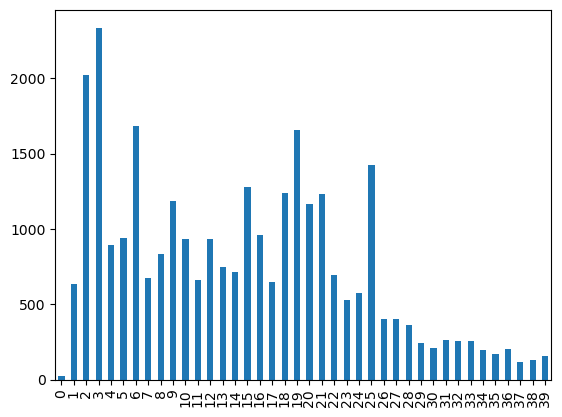

In [53]:
df['len_output'].value_counts().sort_index().plot.bar()